In [1]:
import cv2
import subprocess
import matplotlib.pyplot as plt
import tempfile
import imageio.v3 as iio
import numpy as np
import os

from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

In [2]:
ROOT = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/GX010014.MP4"
# Find out the proper crop
y1 = 550
y2 = 1900
x1 = 1350
x2 = 2650
samples = 1000


In [3]:
vidcap = cv2.VideoCapture(ROOT)
vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

3165.0

In [4]:
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 46)
success, frame = vidcap.read()

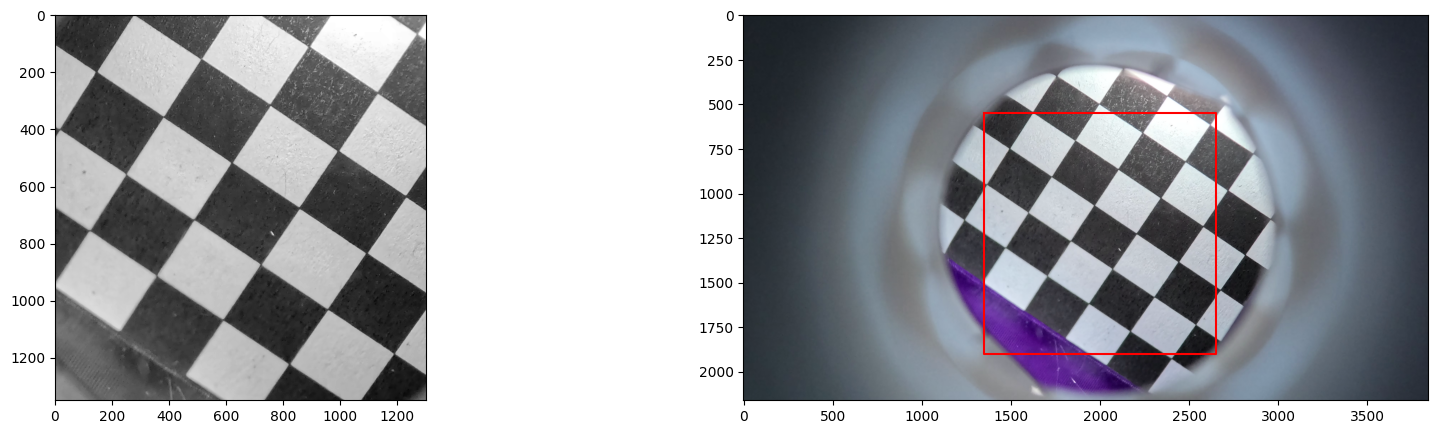

In [5]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(121)
ax.imshow(frame[y1:y2, x1:x2,0], cmap="gray")
ax = plt.subplot(122)
ax.imshow(frame)
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.show()

In [6]:
def unixPathToWinPath(path):
    return path.replace("/mnt/c/", "C:/").replace("/", "\\\\")

def winPathToUnixPath(path):
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [ ]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(21220, 21300, frame_rate),  desc="Processing frames"):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    undistorted =  frame[y1:y2, x1:x2, 0]
    undistorted = cv2.resize(undistorted, (undistorted.shape[0]//4, undistorted.shape[1]//4))
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        
        output_path = tmpfile.name.replace(".pgm", ".txt")
        
        process = subprocess.Popen(
            ["wsl", "devernay", winPathToUnixPath(tmpfile.name),
             "-t", winPathToUnixPath(output_path),
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             # "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/sample{i}.pdf",
             "-s", f"1"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        tmpfile.close()
        
    # Wait for the process to complete and get stdout and stderr
    stdout, stderr = process.communicate()
    
    # Check for errors in stderr
    if stderr:
        print("Error running devernay:", stderr.decode("utf-8"))
    if os.path.exists(output_path):
        with open(output_path, 'r') as output_file:
            result = output_file.read()
    else:
        print(f"Output file {output_path} does not exist.")

    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan

    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))

    if filename is not None and os.path.exists(filename):
        os.remove(filename)

    # counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    # frame_angles.append(values[np.argmax(counts)])

In [ ]:
fid = 14
counts, values = np.histogram(hists[fid], bins=samples)
sigma = 1 # Adjust sigma to control the level of smoothing
smoothed_counts = gaussian_filter1d(counts, sigma=sigma)

# Plot the original and smoothed histograms
plt.figure(figsize=(10, 6))
plt.plot(values[:-1], counts, label="Original Histogram", color="blue", alpha=0.7)
plt.plot(values[:-1], smoothed_counts, label="Smoothed Histogram", color="red", linestyle="--", alpha=0.7)

In [ ]:
fid = 14
counts, values = np.histogram(hists[fid], bins=samples)
best = values[np.argmax(counts)]
plt.hist(hists[fid], bins=samples)
plt.axvline(best, color="red")
plt.title(best)
plt.show()

In [ ]:
frame_angles_smoothed = []
for hist in hists:
    counts, values = np.histogram(hist, bins=samples)
    counts = gaussian_filter1d(counts, sigma=3)
    max_index = np.argmax(counts)
    frame_angles_smoothed.append(values[max_index])

In [3]:
frame_angles_smoothed = np.load("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010010-full_angles.npy")

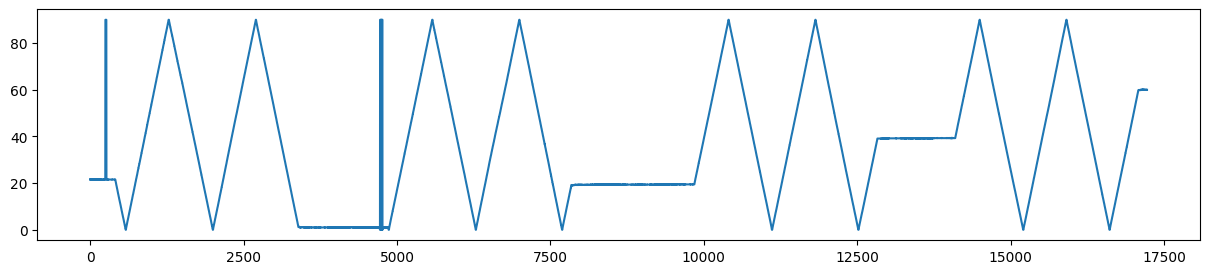

In [4]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [5]:
frame_angles_smoothed_smoothed = savgol_filter(frame_angles_smoothed, window_length=8, polyorder=1)  # Adjust window_length and polyorder based on your data

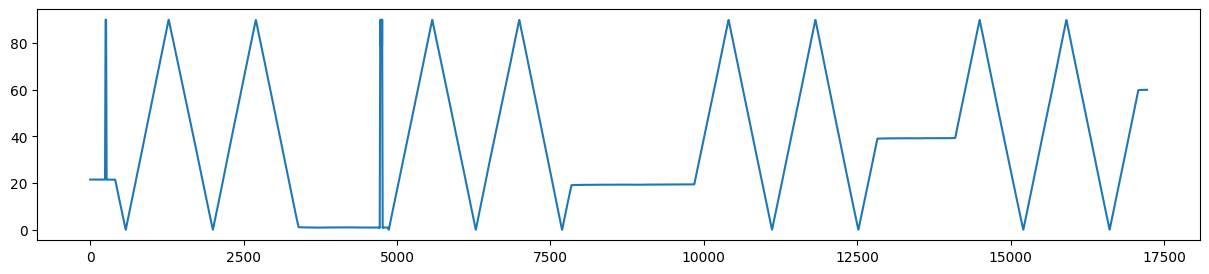

In [6]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [7]:
derivative = np.diff(frame_angles_smoothed_smoothed)
threshold = 0.04 # Adjust this threshold based on your data

segment_type = np.zeros_like(derivative)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing

segment_type[derivative > threshold] = 1  # Increasing
segment_type[derivative < -threshold] = -1  # Decreasing
# Constant parts are already set to 0


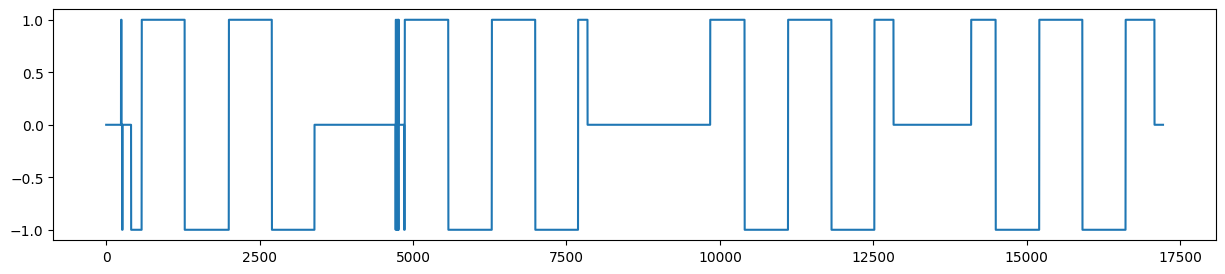

In [8]:
plt.figure(figsize=(15,3))
plt.plot(segment_type)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [9]:
breakpoints = np.where(np.diff(segment_type) != 0)[0] + 1  # +1 because np.diff shifts indices by 1

In [10]:
breakpoints

array([  242,   250,   259,   267,   406,   578,   580,  1279,  1998,
        2000,  2699,  2701,  3394,  4717,  4718,  4726,  4734,  4735,
        4742,  4743,  4748,  4749,  4756,  4757,  4758,  4766,  4767,
        4855,  4864,  4865,  5574,  5575,  6283,  6284,  6991,  6993,
        7689,  7690,  7843,  9842, 10402, 10403, 11110, 11112, 11817,
       11818, 12517, 12518, 12829, 14094, 14493, 14495, 15203, 15205,
       15906, 15908, 16610, 16612, 17081])

In [11]:
threshold = 10
step = 1
# Define the distance threshold to group close breakpoints

merged_breakpoints = []

# Temporary group for close breakpoints
current_group = [breakpoints[0]]

# Iterate over the breakpoints
for i in range(1, len(breakpoints)):
    # print(breakpoints[i], breakpoints[i - 1], breakpoints[i] - breakpoints[i - 1] <= threshold)
    # If the difference between consecutive breakpoints is below the threshold, group them
    if breakpoints[i] - breakpoints[i - 1] <= threshold:
        current_group.append(breakpoints[i])
    else:
        # If a current group is finished, calculate the rounded average and store it
        avg_breakpoint = int(round(np.mean(current_group)))
        merged_breakpoints.append(avg_breakpoint)
        # Start a new group
        current_group = [breakpoints[i]]

# Handle the last group
if current_group:
    avg_breakpoint = int(round(np.mean(current_group)))
    merged_breakpoints.append(avg_breakpoint)

# print(np.asarray(merged_breakpoints))

if len(merged_breakpoints) > 1:
    if stats.mode(segment_type[:merged_breakpoints[0]//step])[0] == stats.mode(segment_type[merged_breakpoints[0]//step:merged_breakpoints[1]//step])[0]:
        new_merged_breakpoints = []
    else:
        new_merged_breakpoints = [merged_breakpoints[0]]

    for i in range(1, len(merged_breakpoints) - 1):
        # print(i, stats.mode(self.segment_type[merged_breakpoints[i - 1]:merged_breakpoints[i]])[0], stats.mode(self.segment_type[merged_breakpoints[i]:merged_breakpoints[i + 1]])[0])
        if not stats.mode(segment_type[merged_breakpoints[i - 1]//step:merged_breakpoints[i]//step])[0] == stats.mode(segment_type[merged_breakpoints[i]//step:merged_breakpoints[i + 1]//step])[0]:
            new_merged_breakpoints.append(merged_breakpoints[i])

    if not stats.mode(segment_type[merged_breakpoints[-1]//step:])[0] == stats.mode(segment_type[merged_breakpoints[-2]//step:merged_breakpoints[-1]//step])[0]:
        new_merged_breakpoints.append(merged_breakpoints[-1])

new_merged_breakpoints = np.concatenate([[0], new_merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])
# Now merged_breakpoints contains the final list of unique breakpoints
print("Merged Breakpoints:", new_merged_breakpoints)


Merged Breakpoints: [    0   406   579  1279  1999  2700  3394  4861  5574  6284  6992  7690
  7843  9842 10402 11111 11818 12518 12829 14094 14494 15204 15907 16611
 17081 17221]


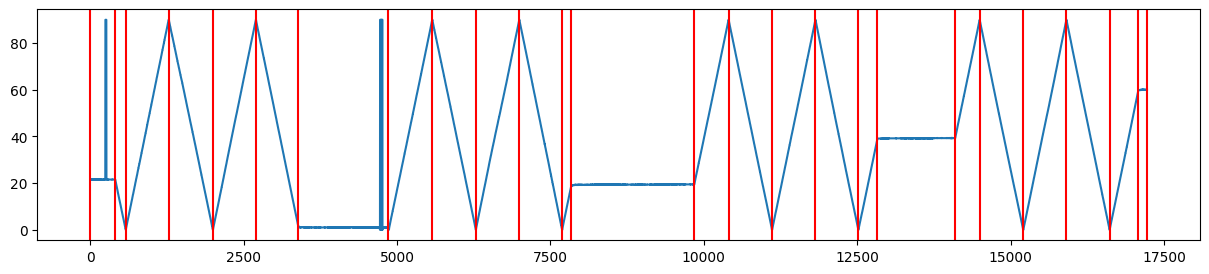

In [12]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.plot(segment_type)
for bp in new_merged_breakpoints:
    plt.axvline(bp, color="red")
plt.show()

In [13]:
borderBreakpoints = []
for i in range(0, len(new_merged_breakpoints) - 1):
    if stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0] == 0:
        borderBreakpoints.append([new_merged_breakpoints[i], new_merged_breakpoints[i + 1]])

print(f"Calculated: Border Breakpoints\n"
      f"{np.asarray(borderBreakpoints)}\n")

Calculated: Border Breakpoints
[[    0   406]
 [ 3394  4861]
 [ 7843  9842]
 [12829 14094]
 [17081 17221]]



In [21]:
np.max(frame_angles_smoothed)

np.float32(89.91)

In [22]:
frame_angles_smoothed[3090:3100]

array([40.140003, 39.960003, 39.870003, 39.690002, 39.600002, 39.510002,
       39.33    , 39.15    , 39.06    , 38.88    ], dtype=float32)

In [23]:
np.where(np.array(frame_angles_smoothed)==np.min(frame_angles_smoothed))

(array([  577,   578,   579,   580,   581,   582,  1997,  1998,  1999,
         2000,  2001,  4722,  4739,  4753,  4763,  4862,  4863,  4864,
         4865,  4866,  4867,  4868,  6282,  6283,  6284,  6285,  6286,
         7687,  7688,  7689,  7690,  7691,  7692,  7693, 11109, 11110,
        11111, 11112, 11113, 12516, 12517, 12518, 12519, 12520, 15202,
        15203, 15204, 15205, 15206, 15207, 16610, 16611, 16612, 16613,
        16614]),)

In [24]:
np.where(np.array(frame_angles_smoothed)==np.max(frame_angles_smoothed))

(array([  247,   248,   249,   250,   251,   252,   253,   254,   255,
          256,   257,   258,   259,   260,   261,   262,   263,  1276,
         1277,  1278,  1279,  1280,  1281,  1282,  1283,  2698,  2699,
         2700,  2701,  2702,  4723,  4724,  4725,  4726,  4727,  4728,
         4729,  4730,  4731,  4732,  4733,  4734,  4735,  4736,  4737,
         4738,  4740,  4741,  4742,  4743,  4744,  4745,  4746,  4747,
         4748,  4749,  4750,  4751,  4752,  4754,  4755,  4756,  4757,
         4758,  4759,  4760,  4761,  4762,  5572,  5573,  5574,  5575,
         5576,  5577,  5578,  6990,  6991,  6992,  6993,  6994,  6995,
        10401, 10402, 10403, 10404, 10405, 11816, 11817, 11818, 11819,
        11820, 14492, 14493, 14494, 14495, 14496, 15906, 15907, 15908,
        15909, 15910]),)

In [24]:
new_merged_breakpoints[13]

np.int64(9842)

1 1 0 0
2 1 0 0
3 1 1 -180
4 1 1 -180
5 1 2 -360
7 2 2 -360
8 2 3 -540
9 2 3 -540
10 2 4 -720
11 2 4 -720
13 3 4 -720
14 3 5 -900
15 3 5 -900
16 3 6 -1080
17 3 6 -1080
19 4 6 -1080
20 4 7 -1260
21 4 7 -1260
22 4 8 -1440
23 4 8 -1440


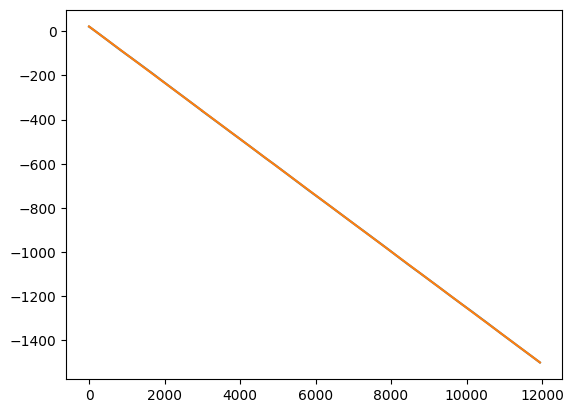

Calculated : RotationPerFrame
0.12739665243907766


In [28]:
fa = []
j = 0
k = 0
start, end = borderBreakpoints[j]
for i in range(0, len(new_merged_breakpoints)-1):
# for i in range(0, 14):
    if not start == new_merged_breakpoints[i]:
        segment = stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0]
        offset = -(k * 180)
        print(i, j, k, offset)
        if segment == 1 and not start == new_merged_breakpoints[i+1]:
            k += 1
        f = frame_angles_smoothed[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]] * -segment + offset
        fa = np.concatenate([fa, f])
    else:
        j += 1
        if j < len(borderBreakpoints):
            start, end = borderBreakpoints[j]

a, b = np.polyfit(np.arange(len(fa)), fa, 1)

plt.plot(fa)
plt.plot([(a * x + b) for x in np.arange(len(fa))])
plt.show()

print(f"Calculated : RotationPerFrame\n"
      f"{-a}")

In [ ]:
# fa = np.concatenate([frame_angles_smoothed[96:488], -frame_angles_smoothed[488:1198], -180 + frame_angles_smoothed[1198: 1895], -180 - frame_angles_smoothed[1895: 2603], -360 + frame_angles_smoothed[2603: 3095]])
a, b = np.polyfit(np.arange(len(fa)), fa, 1)

In [ ]:
plt.plot(fa)
plt.plot([(a*x + b) for x in np.arange(len(fa))])
plt.show()

In [ ]:
rot = -a
angle = -rot*(487-98)
rotated = []

vidcap = cv2.VideoCapture(ROOT)

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 3095-98

success, frame = vidcap.read()

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 98)

out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*'h264'),
                      fps=20.0,
                      frameSize=(y2-y1, x2-x1),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ]
                      )

for i in tqdm(range(total_frames), desc="Processing frames"):
    success, frame = vidcap.read()
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1)    
    rotated_image = cv2.warpAffine( 
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[y1: y2, x1:x2, 0]
    
    out.write(rotated_image.astype(np.uint8))
    
    angle += rot
    
out.release()

In [ ]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=10.0,
                      frameSize=(rotated[0].shape[1], rotated[0].shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ])
for frame in tqdm(rotated):
    out.write(frame.astype(np.uint8))
out.release()


In [ ]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(121)
ax.imshow(rotated[10], cmap="gray")
ax = plt.subplot(122)
ax.imshow(rotated[200], cmap="gray")
plt.show()

In [ ]:
np.max(rotated)

In [ ]:
rot